# Call pacbio consensus UMI sequences

In [1]:
from alignparse.constants import CBPALETTE
import alignparse.ccs
import alignparse.consensus

from Bio.Seq import Seq

import numpy as np

import pandas as pd

import plotnine as p9

import os
import warnings


In [2]:
mutation_df = '../results/pacbio/hashing_highMOI_mutations_str_ex.csv.gz'
cell_df = '../results/viral_tags_bcs_in_cells/hashing_highMOI_cell_barcodes_with_viral_tags.csv.gz'

In [3]:
mutations = pd.read_csv(mutation_df, compression='gzip', low_memory=False)
cell_barcodes = pd.read_csv(cell_df, compression='gzip', low_memory=False)

In [4]:
# create column that removed termini3 mutations

mutations['all_mutations_orf_numbered_noT3'] = mutations.apply(lambda row : str(row['all_mutations_orf_numbered']).replace(str(row['termini3_mutations_orf_numbered']), ''), axis=1)


In [5]:
filter_col = [col for col in mutations
                       if col.startswith('variant_tag')]

mutations = mutations.drop(columns = filter_col)
mutations = mutations.drop(columns = ['name'])

mutations.head()

,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,sequenced_ORF_2_mutations,...,sequenced_ORF_1_mutations_orf_numbered,sequenced_ORF_2_mutations_orf_numbered,termini5_mutations_orf_numbered,termini3_mutations_orf_numbered,target,all_mutations_orf_numbered,gene,transcript,tag_status,all_mutations_orf_numbered_noT3
0,m54228_201020_194205/4194462/ccs,0,0,NaN,1.0,ins209GAAAA,1.000000,ins422A,0.999817,NaN,...,ins1253A,NaN,NaN,ins1910GAAAA,HAmid,ins1253A ins1910GAAAA,fluHA,fluHA,syn,ins1253A
1,m54228_201020_194205/4194571/ccs,0,0,NaN,1.0,del1to208,NaN,del559to870,1.000000,NaN,...,del1390to1701,NaN,NaN,del1702to1909,HAmid,del1390to1701 del1702to1909,fluHA,fluHA,missing one or more tags,del1390to1701
2,m54228_201020_194205/4194630/ccs,0,0,NaN,1.0,ins209AAAAA,0.999409,T345C,0.999998,NaN,...,T1176C,NaN,NaN,ins1910AAAAA,HAmid,T1176C ins1910AAAAA,fluHA,fluHA,chimeric tags,T1176C
3,m54228_201020_194205/4194734/ccs,0,0,NaN,1.0,del1to208,NaN,T365C ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAA...,0.999210,NaN,...,T1196C ins1242CAACCACCTGGAAAAAAAAAAAAAAAAAAAAA...,NaN,NaN,del1702to1909,HAmid,T1196C del1242to1701 ins1242CAACCACCTGGAAAAAAA...,fluHA,fluHA,missing one or more tags,T1196C del1242to1701 ins1242CAACCACCTGGAAAAAAA...
4,m54228_201020_194205/4194868/ccs,0,1,NaN,1.0,del1to46 ins207ACA G208A,1.000000,ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.999988,NaN,...,ins1242CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,NaN,NaN,del1702to1747 ins1908ACA G1909A,HAmid,del1242to1701 ins1242CAACCACCTGGAAAAAAAAAAAAAA...,fluHA,fluHA,missing one or more tags,del1242to1701 ins1242CAACCACCTGGAAAAAAAAAAAAAA...


In [6]:
col_one_list = mutations['cellbarcode_sequence'].tolist()


In [7]:
barcode_list=[]
for barcode in col_one_list:
    seq = Seq(barcode)
    rv_barcode = seq.reverse_complement()
    rv_barcode = str(rv_barcode)
    barcode_list.append(rv_barcode)
barcode_list 
mutations['cellbarcode_rv'] = pd.DataFrame(barcode_list,columns=['cellbarcode_rv'])
mutations.head()

,query_name,query_clip5,query_clip3,termini5_mutations,termini5_accuracy,termini3_mutations,termini3_accuracy,sequenced_ORF_1_mutations,sequenced_ORF_1_accuracy,sequenced_ORF_2_mutations,...,sequenced_ORF_2_mutations_orf_numbered,termini5_mutations_orf_numbered,termini3_mutations_orf_numbered,target,all_mutations_orf_numbered,gene,transcript,tag_status,all_mutations_orf_numbered_noT3,cellbarcode_rv
0,m54228_201020_194205/4194462/ccs,0,0,NaN,1.0,ins209GAAAA,1.000000,ins422A,0.999817,NaN,...,NaN,NaN,ins1910GAAAA,HAmid,ins1253A ins1910GAAAA,fluHA,fluHA,syn,ins1253A,GTGAGTTCATCCTAAG
1,m54228_201020_194205/4194571/ccs,0,0,NaN,1.0,del1to208,NaN,del559to870,1.000000,NaN,...,NaN,NaN,del1702to1909,HAmid,del1390to1701 del1702to1909,fluHA,fluHA,missing one or more tags,del1390to1701,CTCTCAGTCTACCAGA
2,m54228_201020_194205/4194630/ccs,0,0,NaN,1.0,ins209AAAAA,0.999409,T345C,0.999998,NaN,...,NaN,NaN,ins1910AAAAA,HAmid,T1176C ins1910AAAAA,fluHA,fluHA,chimeric tags,T1176C,TCGGGACAGTGTACAA
3,m54228_201020_194205/4194734/ccs,0,0,NaN,1.0,del1to208,NaN,T365C ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAA...,0.999210,NaN,...,NaN,NaN,del1702to1909,HAmid,T1196C del1242to1701 ins1242CAACCACCTGGAAAAAAA...,fluHA,fluHA,missing one or more tags,T1196C del1242to1701 ins1242CAACCACCTGGAAAAAAA...,TCATTGTTCAACCTTT
4,m54228_201020_194205/4194868/ccs,0,1,NaN,1.0,del1to46 ins207ACA G208A,1.000000,ins411CAACCACCTGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0.999988,NaN,...,NaN,NaN,del1702to1747 ins1908ACA G1909A,HAmid,del1242to1701 ins1242CAACCACCTGGAAAAAAAAAAAAAA...,fluHA,fluHA,missing one or more tags,del1242to1701 ins1242CAACCACCTGGAAAAAAAAAAAAAA...,TTTGGTTGTGGCCCAT


In [8]:
df_merged = pd.merge(mutations, cell_barcodes,
                       how='left', left_on=['cellbarcode_rv'],
                       right_on=['cell_barcode'])

In [9]:
# filter for  cells that don't have chimeric tags
df_merged = df_merged.loc[df_merged['tag_status'] != 'chimeric tags']

## CCSs in infected and uninfected cells

In [10]:
print('How many CCSs are called in infected vs uninfected cells:')
df_merged.groupby(['infected']).agg({'infected': 'count'})

How many CCSs are called in infected vs uninfected cells:


,infected
infected,
False,357
True,169129


### CCSs in uninfected cells

In [11]:
uninfected = df_merged.loc[df_merged['infected'] == False]
uninfected_barcode_count = (
                            uninfected
                            .groupby(['cell_barcode'])
                            .agg({'cell_barcode': 'count'})
)
uninfected_barcode_count = (
                            uninfected_barcode_count
                            .rename(columns={'cell_barcode': 'cell_barcode',
                                             'cell_barcode': 'count'})
)


In total we find 202 unique barcodes that are counted as uninfected based on illumina sequencing 
This is how CCSs are distributed in uninfected cells:


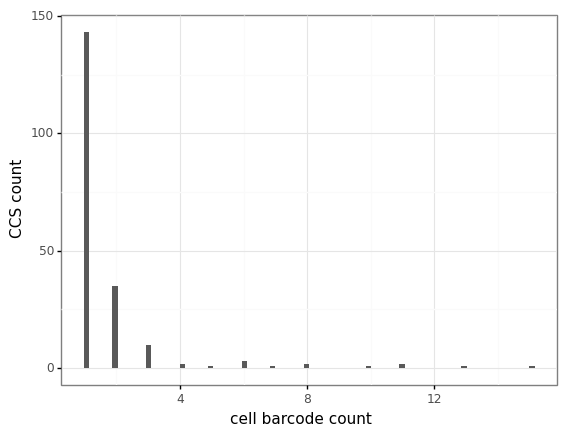

In [12]:
p = (
    p9.ggplot(uninfected_barcode_count,
              p9.aes(x = 'count'))
    + p9.geom_histogram(bins=80)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.theme_bw()
    + p9.xlab("cell barcode count")
    + p9.ylab("CCS count")
)
_ = p.draw()
print('In total we find', len(uninfected_barcode_count.index), 
      'unique barcodes that are counted as uninfected based on illumina sequencing ')
print('This is how CCSs are distributed in uninfected cells:')

### CCSs in infected cells

In [13]:
infected = df_merged.loc[df_merged['infected'] == True]

infected_barcode_count = (
                          infected
                          .groupby(['cell_barcode'])
                          .agg({'cell_barcode': 'count'})
)
infected_barcode_count = (
                          infected_barcode_count
                          .rename(columns={'cell_barcode': 'count'})
)

In total we find 5119 unique infected barcodes
This is how CCSs are distributed per cell barcode:


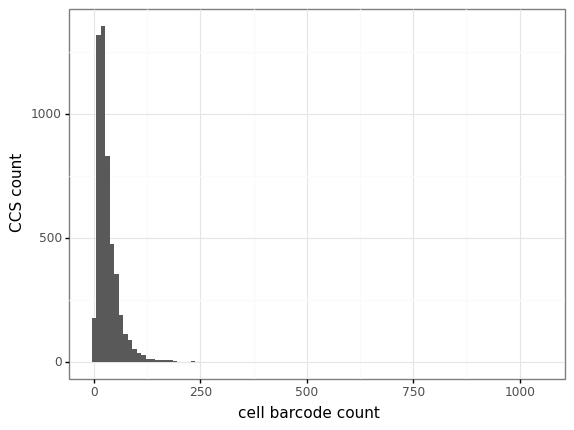

In [14]:
p = (
    p9.ggplot(infected_barcode_count,
              p9.aes(x = 'count'))
    + p9.geom_histogram(bins=100)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.theme_bw()
    + p9.xlab("cell barcode count")
    + p9.ylab("CCS count")
)
_ = p.draw()

print('In total we find', len(infected_barcode_count.index), 'unique infected barcodes')
print('This is how CCSs are distributed per cell barcode:')

## UMI counts

Here we count unique UMIs. We group by cell barcode + gene + UMI to identify unique UMIs.

In [15]:
UMI_count = df_merged.groupby(['UMI_sequence', 'cell_barcode', 'gene']).agg({'UMI_sequence': 'count'})
UMI_count = UMI_count.rename(columns={'UMI_sequence': 'UMI', 'UMI_sequence': 'count'})
UMI_count.head()

count
UMI_sequence cell_barcode     gene         
AAAAAAAAAAAA CAGCAATAGTCACAGG fluPB2      1
             CCACAAAAGATTAGAC fluPB2      1
             CGTCAAACACAAACGG fluPB1      1
             TTGTGGATCATTTGCT fluPB1      1
AAAAAAAAAAAC ACCATTTCAGAACTTC fluPA       1

max number of CCSs per UMI is 5


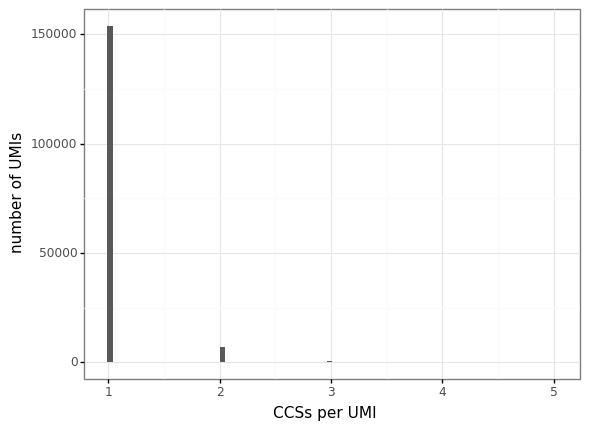

In [16]:
p = (
    p9.ggplot(UMI_count,
              p9.aes(x = 'count'))
    + p9.geom_histogram(bins=80)
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.theme_bw()
    + p9.xlab("CCSs per UMI")
    + p9.ylab("number of UMIs")
)
_ = p.draw()

print('max number of CCSs per UMI is', UMI_count['count'].max())

In [17]:
UMI_count_table = (
                  UMI_count
                  .rename(columns={'count': 'no_of_CCSs'})
                  .groupby(['no_of_CCSs'])
                  .agg({'no_of_CCSs': 'count'})
)
print('Here\'s how many CCSs each UMI has:')
UMI_count_table.rename(columns={'no_of_CCSs': 'no of UMIs'})

Here's how many CCSs each UMI has:


,no of UMIs
no_of_CCSs,
1,153700
2,7046
3,505
4,36
5,7


# Call consensus per UMI

Here we'll call per UMI consensus only in infected cells.

In [18]:
# remove duplicate mutation strings
all_mutations_orf_numbered_dupRM = infected['all_mutations_orf_numbered_noT3'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')
infected['all_mutations_orf_numbered_noT3_dupRM'] = all_mutations_orf_numbered_dupRM

<ipython-input-18-4df86bb70714>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Call consensus on mutations on `all_mutations_orf_numbered_noT3_dupRM` column that has mutations in 3' termini and duplicated mutations removed.

In [19]:
infected = infected.replace(np.nan, '', regex=True)
infected['all_mutations_orf_numbered_noT3_dupRM'] = infected['all_mutations_orf_numbered_noT3_dupRM'].str.replace('nan','')

consensus, dropped = alignparse.consensus.simple_mutconsensus(
    infected,
    group_cols=['cellbarcode_sequence', 'transcript', 'UMI_sequence'],
    mutation_col='all_mutations_orf_numbered_noT3_dupRM',
    max_sub_diffs=5,
    max_indel_diffs=10,
    max_minor_sub_frac=0.3,
    max_minor_indel_frac=0.3,
    support_col='variant_call_support'
)
consensus.head()

,cellbarcode_sequence,transcript,UMI_sequence,all_mutations_orf_numbered_noT3_dupRM,variant_call_support
0,AAACACCTGCACGCAC,fluHA,AAAAAGAAAACC,del971to1701,1
1,AAACACCTGCACGCAC,fluHA,AGTTGTGACCAT,del1251to1701,1
2,AAACACCTGCACGCAC,fluHA,CTTCGAGGCTAG,T507C del513to1701,1
3,AAACACCTGCACGCAC,fluM1,AAGGTTGACCCG,T980A ins918G ins980GA,1
4,AAACACCTGCACGCAC,fluM1,AGGAGACCGTAA,C54T,1


In [29]:
dropped.head()

,cellbarcode_sequence,transcript,UMI_sequence,drop_reason,nseqs
0,AAGCCGAGAAACGGTG,fluPB2,GGAAGTAACCAC,indels diff too large,2
1,AAGCTAAGAAATGGAT,fluPB2,GCCCTGCAGGTT,indels diff too large,2
2,ACCTTGGCTGGGTGTA,fluPB2,GTAAGGATAACC,indels diff too large,2
3,AGCTACAACGGTAGAC,fluPA,GATGTGATTAAT,indels diff too large,2
4,AGTTTCTACAATGGCG,fluPA,CTCCTTCTCGGG,subs diff too large,2
5,ATGTTGGTGGCATTAC,fluPA,GCGTACTATGTT,subs diff too large,2
6,CCAACTCACATTTCTC,fluPA,AAAACAGGAACC,indels diff too large,2
7,CTAACAGACGGATGAC,fluPA,GATGGATTTGTT,subs diff too large,2
8,CTCATTTGACGCACTG,fluPB2,ACCACTATCCAG,subs diff too large,2
9,CTGATCCACCATTACG,fluPA,TTTCCTTCCGCC,indels diff too large,2


# Call mutation frequencies per cell barcode

First group mutations by cell barcode and segment

## Individual mutation frequencies

Split each mutation string to individual mutations

In [23]:
consensus_expand = (
    consensus
    .set_index(consensus.columns
    .drop('all_mutations_orf_numbered_noT3_dupRM',1).tolist())
    .all_mutations_orf_numbered_noT3_dupRM.str.split(' ', expand=True)
    .stack()
    .reset_index()
    .rename(columns={0:'all_mutations_orf_numbered_noT3_dupRM'})
    .loc[:, consensus.columns]
)
consensus_expand

,cellbarcode_sequence,transcript,UMI_sequence,all_mutations_orf_numbered_noT3_dupRM,variant_call_support
0,AAACACCTGCACGCAC,fluHA,AAAAAGAAAACC,del971to1701,1
1,AAACACCTGCACGCAC,fluHA,AGTTGTGACCAT,del1251to1701,1
2,AAACACCTGCACGCAC,fluHA,CTTCGAGGCTAG,T507C,1
3,AAACACCTGCACGCAC,fluHA,CTTCGAGGCTAG,del513to1701,1
4,AAACACCTGCACGCAC,fluM1,AAGGTTGACCCG,T980A,1
...,...,...,...,...,...
247589,TTTGTAGCTTGGCTGC,fluPB2,TGAGGAGTACTC,A907G,1
247590,TTTGTAGCTTGGCTGC,fluPB2,TGAGGAGTACTC,T2291A,1
247591,TTTGTAGCTTGGCTGC,fluPB2,TGAGGAGTACTC,T2292A,1
247592,TTTGTAGCTTGGCTGC,fluPB2,TGAGGAGTACTC,T2293A,1


In [24]:
consensus_count = (
    consensus_expand
    .groupby(['cellbarcode_sequence','transcript' ])['all_mutations_orf_numbered_noT3_dupRM']
    .value_counts()
    .reset_index(name='counts')
)

consensus_count

,cellbarcode_sequence,transcript,all_mutations_orf_numbered_noT3_dupRM,counts
0,AAACACCTGCACGCAC,fluHA,T507C,1
1,AAACACCTGCACGCAC,fluHA,del1251to1701,1
2,AAACACCTGCACGCAC,fluHA,del513to1701,1
3,AAACACCTGCACGCAC,fluHA,del971to1701,1
4,AAACACCTGCACGCAC,fluM1,C54T,1
...,...,...,...,...
187850,TTTGTAGCTTGGCTGC,fluPB2,T2292A,1
187851,TTTGTAGCTTGGCTGC,fluPB2,T2293A,1
187852,TTTGTAGCTTGGCTGC,fluPB2,del555to2280,1
187853,TTTGTAGCTTGGCTGC,fluPB2,del558to2280,1


In [27]:
consensus_count['mutation_freq_cell'] = (
    consensus_count
    .groupby(['cellbarcode_sequence','transcript' ])['counts']
    .apply(lambda x: x / x.sum())
)

consensus_count['mutation_freq_pool'] = (
    consensus_count
    .groupby('transcript')['counts']
    .apply(lambda x: x / x.sum())
)
consensus_count

,cellbarcode_sequence,transcript,all_mutations_orf_numbered_noT3_dupRM,counts,mutation_freq_cell,mutation_freq_pool
0,AAACACCTGCACGCAC,fluHA,T507C,1,0.250000,0.000057
1,AAACACCTGCACGCAC,fluHA,del1251to1701,1,0.250000,0.000057
2,AAACACCTGCACGCAC,fluHA,del513to1701,1,0.250000,0.000057
3,AAACACCTGCACGCAC,fluHA,del971to1701,1,0.250000,0.000057
4,AAACACCTGCACGCAC,fluM1,C54T,1,0.250000,0.000118
...,...,...,...,...,...,...
187850,TTTGTAGCTTGGCTGC,fluPB2,T2292A,1,0.111111,0.000015
187851,TTTGTAGCTTGGCTGC,fluPB2,T2293A,1,0.111111,0.000015
187852,TTTGTAGCTTGGCTGC,fluPB2,del555to2280,1,0.111111,0.000015
187853,TTTGTAGCTTGGCTGC,fluPB2,del558to2280,1,0.111111,0.000015


In [28]:
consensus_count[consensus_count['cellbarcode_sequence'] == 'AAACACCTGCACGCAC']

,cellbarcode_sequence,transcript,all_mutations_orf_numbered_noT3_dupRM,counts,mutation_freq_cell,mutation_freq_pool
0,AAACACCTGCACGCAC,fluHA,T507C,1,0.250000,0.000057
1,AAACACCTGCACGCAC,fluHA,del1251to1701,1,0.250000,0.000057
2,AAACACCTGCACGCAC,fluHA,del513to1701,1,0.250000,0.000057
3,AAACACCTGCACGCAC,fluHA,del971to1701,1,0.250000,0.000057
4,AAACACCTGCACGCAC,fluM1,C54T,1,0.250000,0.000118
5,AAACACCTGCACGCAC,fluM1,T980A,1,0.250000,0.000118
6,AAACACCTGCACGCAC,fluM1,ins918G,1,0.250000,0.000118
7,AAACACCTGCACGCAC,fluM1,ins980GA,1,0.250000,0.000118
8,AAACACCTGCACGCAC,fluNA,,2,0.222222,0.000115
9,AAACACCTGCACGCAC,fluNA,A87G,1,0.111111,0.000058


In [ ]:
consensus_count['mutation_freq_pool'].max()

## UMI mutation group frequencies

In [ ]:
consensus_countGR = (
    consensus
    .explode('all_mutations_orf_numbered_noT3_dupRM')
    .groupby(['cellbarcode_sequence','transcript' ])['all_mutations_orf_numbered_noT3_dupRM']
    .value_counts()
    .reset_index(name='counts')
)
consensus_countGR


In [ ]:

consensus_countGR['mutation_freq_cell'] = (
    consensus_countGR
    .groupby(['cellbarcode_sequence','transcript' ])['counts']
    .apply(lambda x: x / x.sum())
)

consensus_countGR['mutation_freq_pool'] = (
    consensus_countGR
    .groupby('transcript')['counts']
    .apply(lambda x: x / x.sum())
)
consensus_countGR